In [1]:
import csv
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import plotly.express as px
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [3]:
# Create a DataFrame from the data
def create_dataframe(data):
    dataframe = pd.DataFrame(data)
    return dataframe

In [4]:
# Preprocess the selected features
def select_https(data):
    data_selected = data[data['url'].str.startswith('https')].copy()
    return data_selected

In [5]:
def domain_age_lessThanOne(create_date, update_date):
    if create_date != "" and create_date != "expired" and not pd.isna(create_date):
        age = datetime.strptime("2024-04-23", '%Y-%m-%d') - datetime.strptime(create_date[:10],
                                                                              '%Y-%m-%d')
        return (age.days // 365) < 1

    elif create_date == "" and update_date != "":
        age = datetime.strptime("2024-04-23", '%Y-%m-%d') - datetime.strptime(update_date[:10],
                                                                              '%Y-%m-%d')
        if age.days < 365:
            return None
        else:
            return False

    elif create_date == "expired":
        return True

    return None

In [6]:
def binary_to_numeric(value):
    if value:
        return 1
    if not value:
        return 0
    else:
        return None

In [7]:
def preprocess_data(data, features):
    
    preprocessed_data = data[features].copy()
    preprocessed_data['new_domain'] = None
    for index, item in preprocessed_data.iterrows():
        new_domain = domain_age_lessThanOne(item['creation_date'], item['updated_date'])
        preprocessed_data.loc[index, 'new_domain'] = new_domain
        
    preprocessed_data = preprocessed_data.drop('creation_date', axis=1)
    preprocessed_data = preprocessed_data.drop('updated_date', axis=1)
        
    # Transform binary values to numerical
    preprocessed_data['control_over_dns'] = preprocessed_data['control_over_dns'].astype(float).replace({True: 1.0, False: 0.0})
    preprocessed_data['control_over_ssl'] = preprocessed_data['control_over_ssl'].astype(float).replace({True: 1.0, False: 0.0})
    preprocessed_data['domain_indexed'] = preprocessed_data['domain_indexed'].astype(float).replace({True: 1.0, False: 0.0})
    preprocessed_data['is_archived'] = preprocessed_data['is_archived'].astype(float).replace({True: 1.0, False: 0.0})
    preprocessed_data['known_hosting'] = preprocessed_data['known_hosting'].astype(float).replace({True: 1.0, False: 0.0})
    preprocessed_data['new_domain'] = preprocessed_data['new_domain'].astype(float).replace({True: 1.0, False: 0.0})
    preprocessed_data['is_on_root'] = preprocessed_data['is_on_root'].astype(float).replace({True: 1.0, False: 0.0})
    preprocessed_data['is_subdomain'] = preprocessed_data['is_subdomain'].astype(float).replace({True: 1.0, False: 0.0})
        
    # preprocessed_data =preprocessed_data.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
    
    return preprocessed_data

In [8]:
def encode_categorical_features(data, cat_features):
    for feature in cat_features:
        # Generate one-hot encoded columns
        encoded_features = pd.get_dummies(data[feature], prefix=feature, dummy_na=False)

        # Preserve missing samples
        if data[feature].isnull().any():
            missing_samples = data[feature].isnull()
            missing_columns = [col for col in encoded_features.columns if col.startswith(f'{feature}_')]
            encoded_features[missing_columns] = encoded_features[missing_columns].where(~missing_samples, pd.NA)
            # encoded_features.loc[missing_samples, missing_columns] = pd.NA

        data = pd.concat([data, encoded_features], axis=1)
        data.drop(columns=[feature], inplace=True)  # Drop the original column

        # Iterate over the columns
        for col in data.columns:
            if data[col].apply(lambda x: isinstance(x, bool)).any():  # Check if the column contains boolean values
                data[col] = data[col].astype(float).replace({True: 1.0, False: 0.0})

    return data

In [9]:
# Scale numerical features using standardization
def scale_numerical_features(data, num_features):
    scaler = MaxAbsScaler()
    data[num_features] = scaler.fit_transform(data[num_features])
    return data

In [10]:
def count_missing_values(data, file_name):
    missing_values = data.isnull().sum()
    missing_values.to_csv(file_name)

In [30]:
def handle_missing_values(data, num_features):
    features_with_missing_values = data.columns[data.isnull().any()].tolist()
    features_with_missing_values.sort(key=lambda x: data[x].isnull().sum())

    best_params_dict = {}  # Dictionary to store best parameters for each feature

    for feature in features_with_missing_values:
        complete_data = data.dropna()  # Remove rows with any missing values

        data_null = data[data[feature].isnull()] # Rows from the original DataFrame where the values in the column [feature] are null
        data_pred = data_null.drop(feature, axis=1) # Test data that we want to predict them the column [feature] 

        X_train = complete_data.drop(feature, axis=1)
        y_train = complete_data[feature]

        param_grid = {
            "n_estimators": [100, 200, 500],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10]
        }
        if feature in num_features:
            RF_model = RandomForestRegressor()
            grid_search = GridSearchCV(RF_model, param_grid, cv=5, scoring='neg_mean_squared_error')

        else:
            RF_model = RandomForestClassifier()
            grid_search = GridSearchCV(RF_model, param_grid, cv=5, scoring='accuracy')

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params_dict[feature] = grid_search.best_params_  # Save best parameters for the feature
        imputed_values = best_model.predict(data_pred)
        data.loc[data[feature].isnull(), feature] = imputed_values
        # Calculate accuracy and MSE
        best_scoring = grid_search.best_score_
        print(f"Feature: {feature}, Best Score: {best_scoring}")

    # Save the best parameters dictionary to a file
    joblib.dump(best_params_dict, path_prefix + 'best_params_dict.pkl')

    return data

In [31]:
import pickle
from sklearn.base import clone

def handle_missing_values_load_bestparams(data, num_features):
    features_with_missing_values = data.columns[data.isnull().any()].tolist()
    features_with_missing_values.sort(key=lambda x: data[x].isnull().sum())

    # Load the best parameters from the pickle file
    with open(path_prefix + 'best_params_dict.pkl', 'rb') as f:
        best_params_dict = pickle.load(f)

    for feature in features_with_missing_values:
        complete_data = data.dropna()  # Remove rows with any missing values

        data_null = data[data[feature].isnull()]
        data_pred = data_null.drop(feature, axis=1)

        X_train = complete_data.drop(feature, axis=1)
        y_train = complete_data[feature]

        if feature in num_features:
            RF_model = RandomForestRegressor()
        else:
            RF_model = RandomForestClassifier()

        if feature in best_params_dict:
            best_params = best_params_dict[feature] # Get the best parameters for the feature
        else:
            # Set best_params to default parameters
            default_model = clone(RF_model)
            default_params = default_model.get_params()
            best_params = default_params
            
        RF_model.set_params(**best_params)  # Set the best parameters for the model

        RF_model.fit(X_train, y_train)
        imputed_values = RF_model.predict(data_pred)
        data.loc[data[feature].isnull(), feature] = imputed_values.astype(float) 
        # Calculate accuracy and MSE
        best_scoring = RF_model.score(X_train, y_train)
        print(f"Feature: {feature}, Best Score: {best_scoring}")

    return data

In [32]:
# Perform K-means clustering
class KMeansWithInertia:
    def __init__(self, kmeans, inertia):
        self.kmeans = kmeans
        self.inertia = inertia
        
def perform_clustering(data, n_clusters):
    k_means = KMeans(n_clusters=n_clusters, random_state=42, max_iter=400)
    labels = k_means.fit_predict(data)
    
    # Create the custom object for saving the kmeans model and the interia
    inertia = k_means.inertia_
    kmeans_with_inertia = KMeansWithInertia(k_means, inertia)
    with open(path_prefix + 'kmeans_model_with_inertia.pkl', 'wb') as file:
        pickle.dump(kmeans_with_inertia, file)
        
    return labels

In [14]:
# Assign cluster labels to the original data
def assign_cluster_labels(data, labels):
    clustered_data = data.copy()
    clustered_data['Cluster'] = labels
    return clustered_data

In [15]:
def silhouette_elbow_plot(data):
    # Silhouette visualization
    for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
        model = KMeans(n_clusters=k, max_iter=400)
        visualizer = SilhouetteVisualizer(model)
        visualizer.fit(data)
        visualizer.show()

    # Elbow visualization
    model = KMeans(max_iter=400)
    visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
    visualizer.fit(data)
    visualizer.show()


In [16]:
def plot_tsne(data, labels):
    tsnee = TSNE(n_components=2, random_state=42)
    tsne_result = tsnee.fit_transform(data)

    # Create an interactive scatter plot using plotly
    df_tsne = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
    df_tsne['cluster'] = labels.astype(str)
    df_tsne['index'] = data.index

    fig = px.scatter(df_tsne, x='Dimension 1', y='Dimension 2', color='cluster', hover_data=['index'],
                     title='t-SNE Visualization',  template='plotly_white')
    fig.show()

In [33]:
import matplotlib as plt
def calculate_feature_importance(X, cluster_labels):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, cluster_labels, test_size=0.2, random_state=42)

    # Create and train the Random Forest classifier
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)

    # Predict on the test set
    predictions = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    # Get feature importance scores
    feature_names = X_train.columns
    feature_importance = rf_classifier.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    # Create a dictionary to store feature names and importance scores
    importance_dict = {}

    # Sort feature importance scores in descending order
    sorted_features = sorted(zip(X.columns.tolist(), feature_importance), key=lambda x: x[1], reverse=True)

    # Write feature importance scores to the CSV file
    with open(path_prefix + "feature_importance.csv", 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Feature', 'Importance'])
        for feature, importance in sorted_features:
            importance_dict[feature] = importance
            writer.writerow([feature, importance])

In [18]:
# List of selected features
selected_features = [
    'creation_date',
    'updated_date',
    'control_over_ssl',
    'control_over_dns',
    'domain_indexed',
    'known_hosting',
    'is_archived',
    'is_on_root',
    'is_subdomain',
    'between_archives_distance',
    'phish_archives_distance'
]

In [19]:
numerical_features = ['between_archives_distance', 'phish_archives_distance']

In [23]:
# Load the data
path_prefix = '../data/'
df = pd.read_csv(path_prefix + 'dataset.csv')

In [24]:
# Preprocess the data
transformed_data = preprocess_data(df, selected_features)

In [26]:
# count_missing_values(transformed_data, path_prefix + 'missing_value_count.csv')

In [28]:
# Scale numerical features
scaled_data = scale_numerical_features(transformed_data, numerical_features)

In [35]:
# Handling missing value using RandomForest
handled_missed = handle_missing_values(scaled_data, numerical_features)

In [36]:
# handled_missed.to_csv(path_prefix + 'handled_missed.csv', index=True)

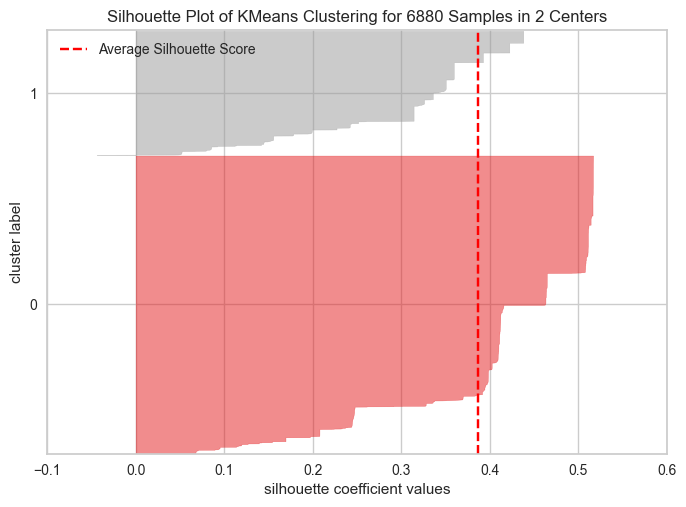

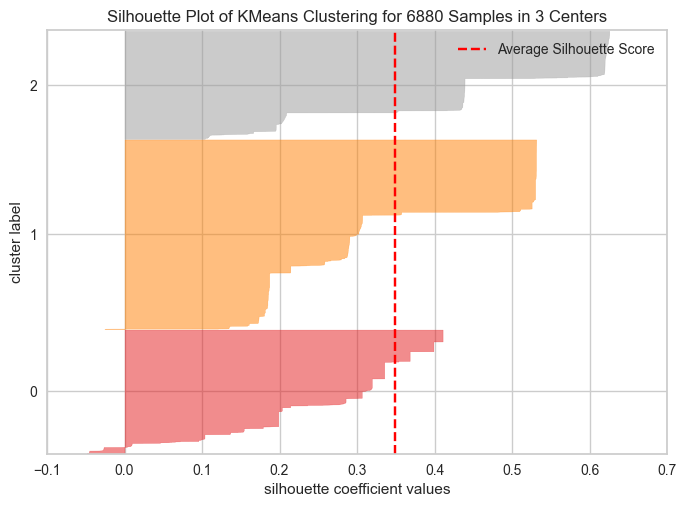

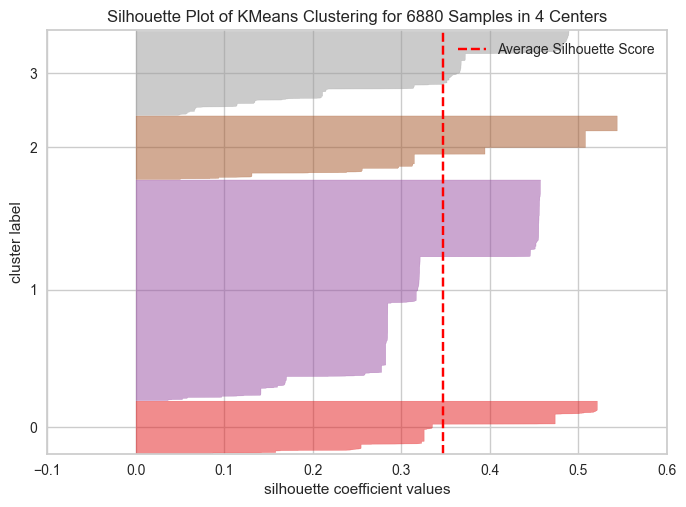

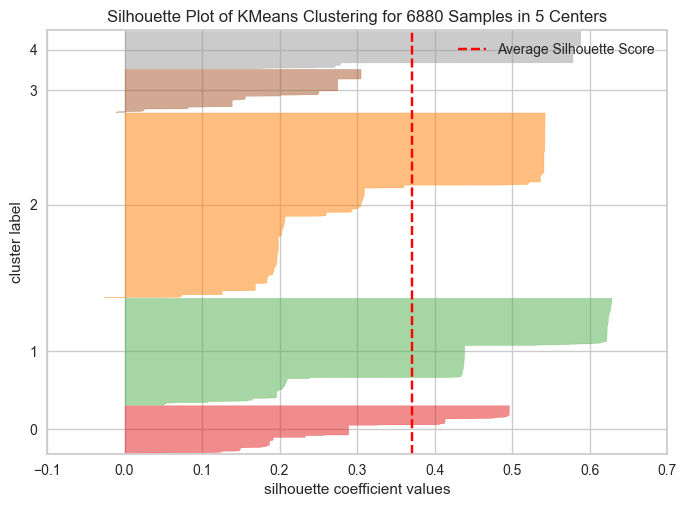

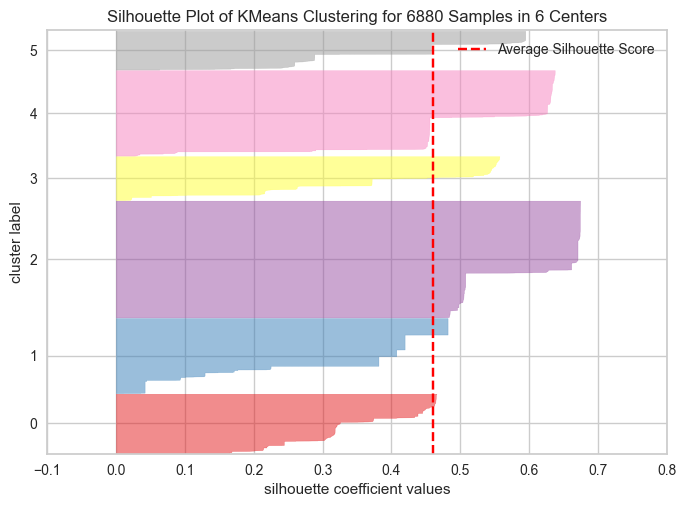

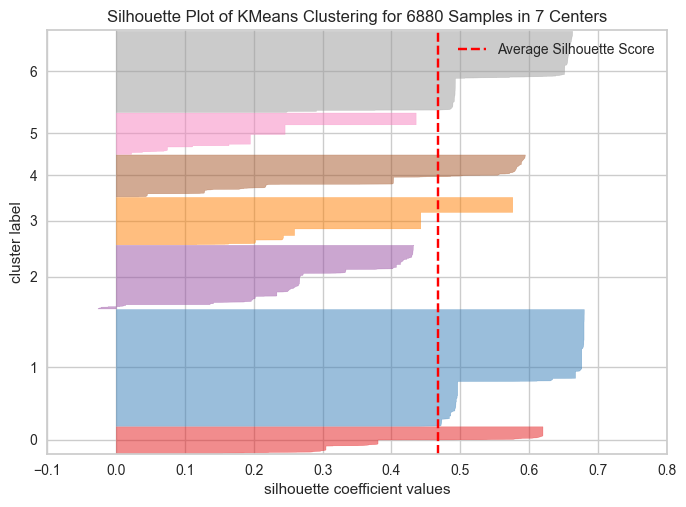

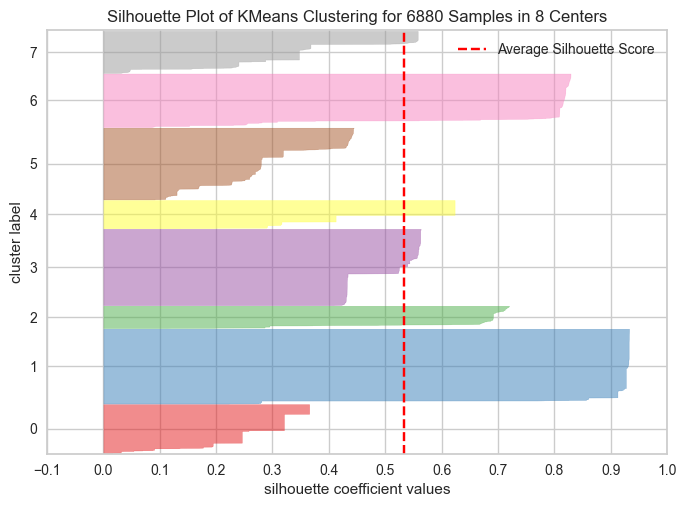

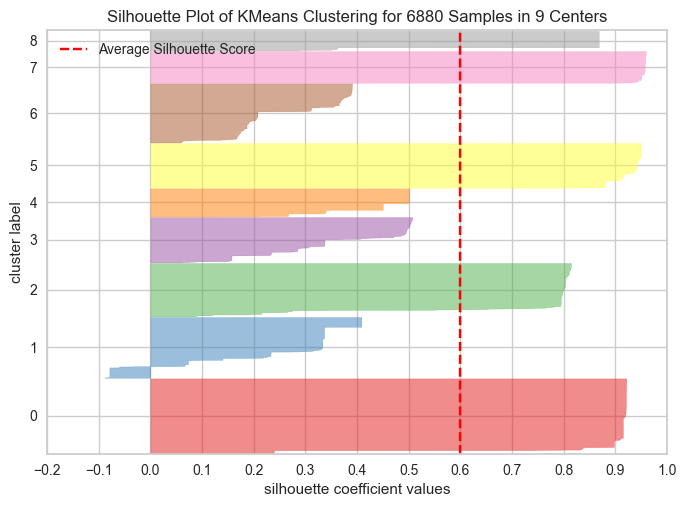

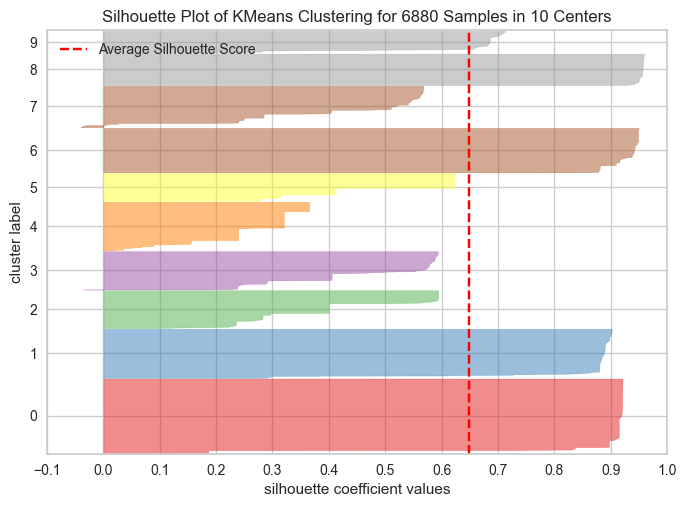

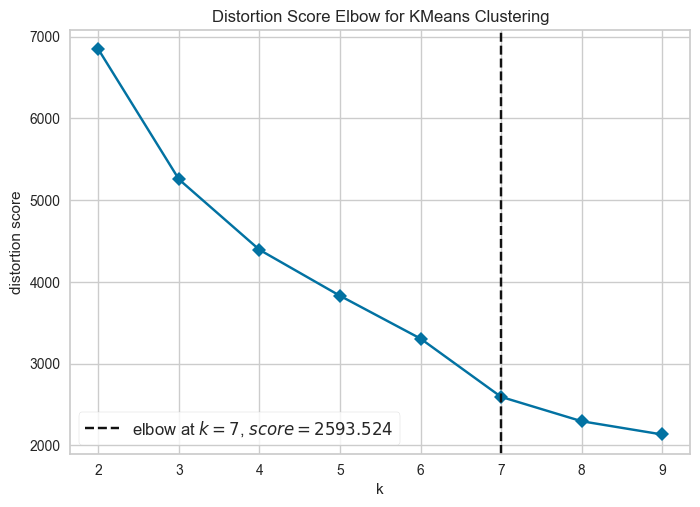

In [49]:
# Silhouette score and elbow
silhouette_elbow_plot(handled_missed)

In [50]:
# K-means clustering
clusters = perform_clustering(handled_missed, n_clusters=7)

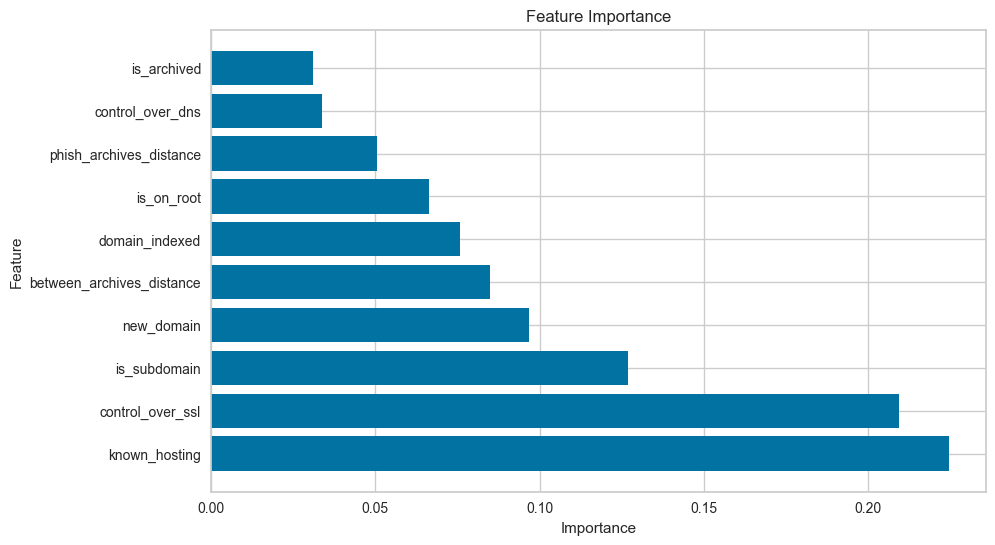

In [51]:
# Features Importance
from matplotlib import pyplot as plt
calculate_feature_importance(handled_missed, clusters)

In [52]:
# Assign cluster labels to the original data
handled_missed_clustered = assign_cluster_labels(handled_missed, clusters)
# handled_missed_clustered.to_csv(path_prefix + 'clustered_data.csv', index=True)

In [53]:
plot_tsne(handled_missed, clusters)

In [54]:
# ################################################################
# SHAP

In [55]:
# Train a supervised learning model using the cluster labels

import shap

model = RandomForestClassifier()
model.fit(handled_missed, clusters)
y_pred = model.predict(handled_missed)

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(handled_missed)


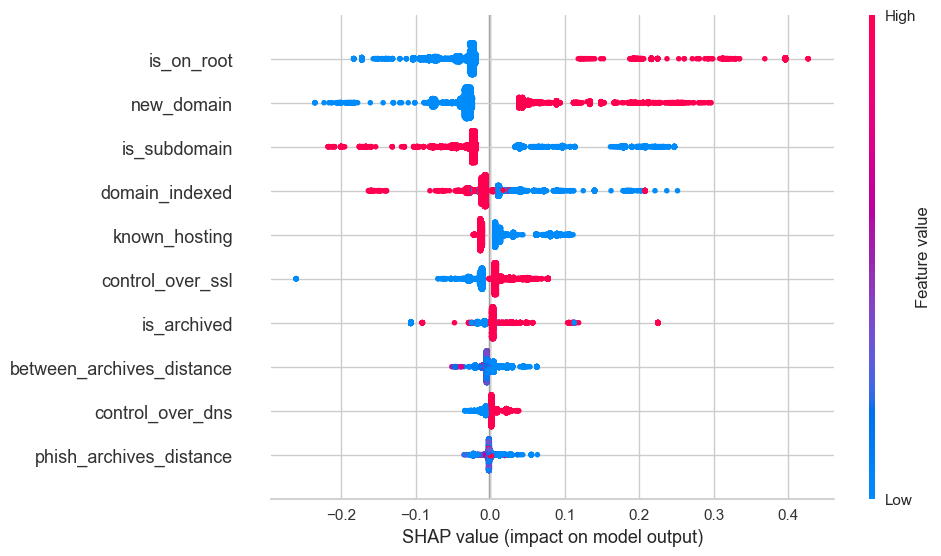

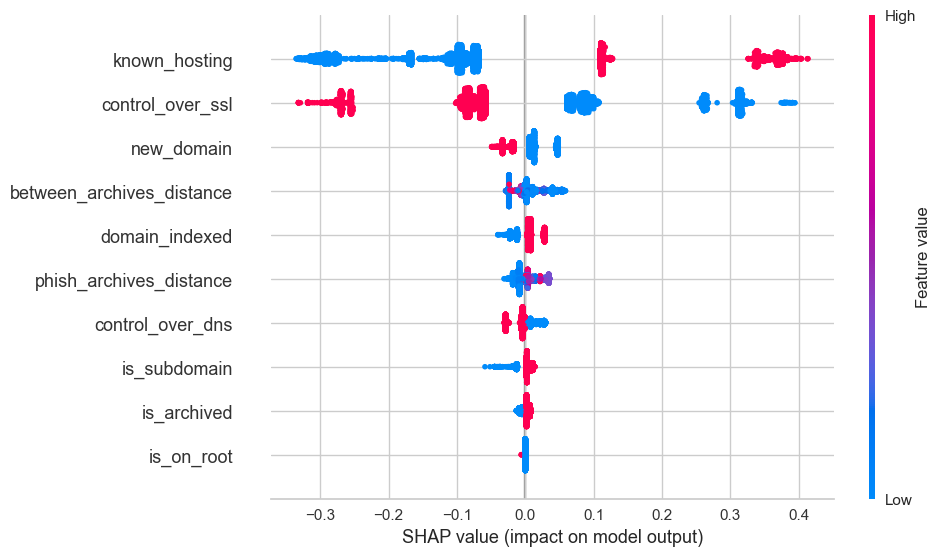

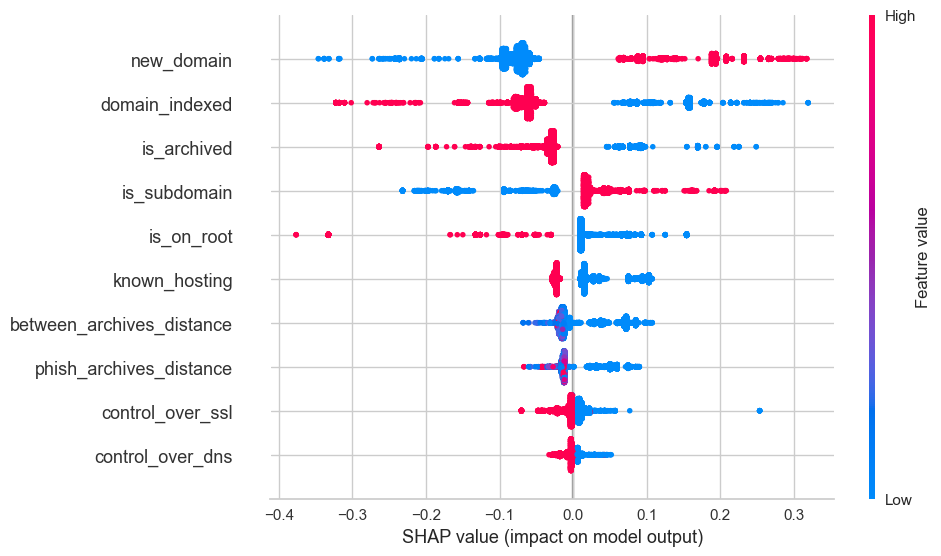

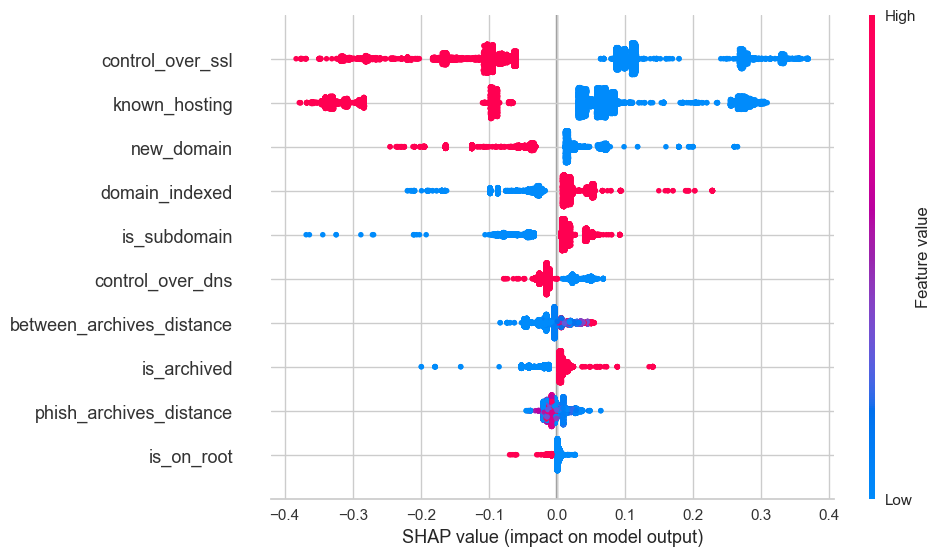

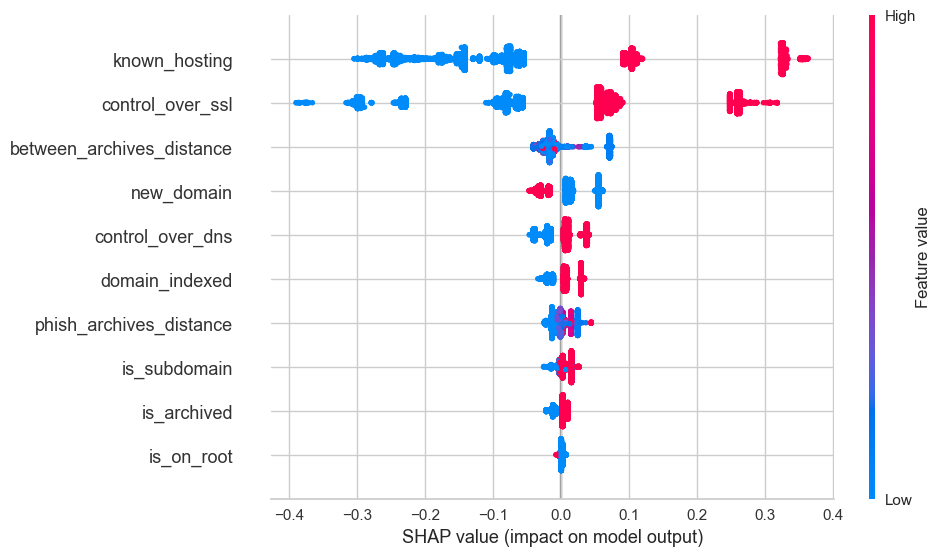

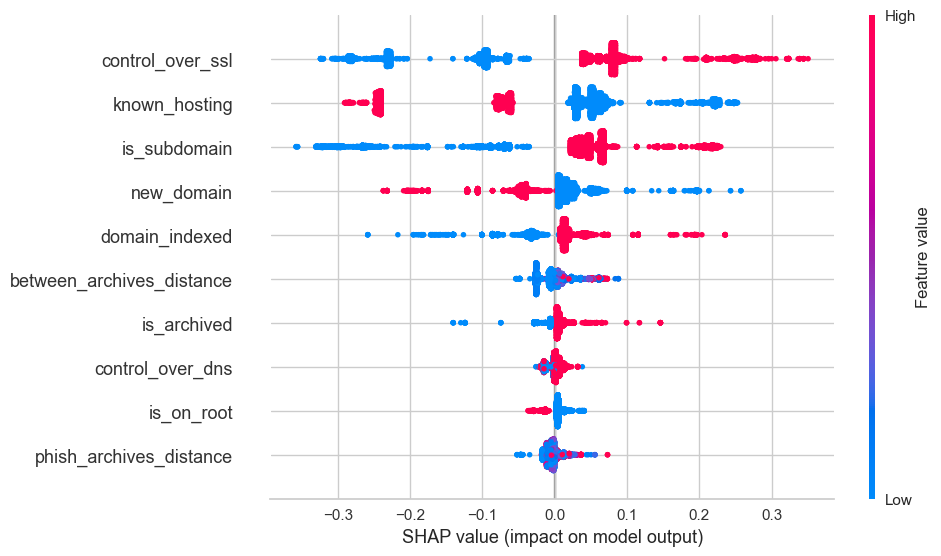

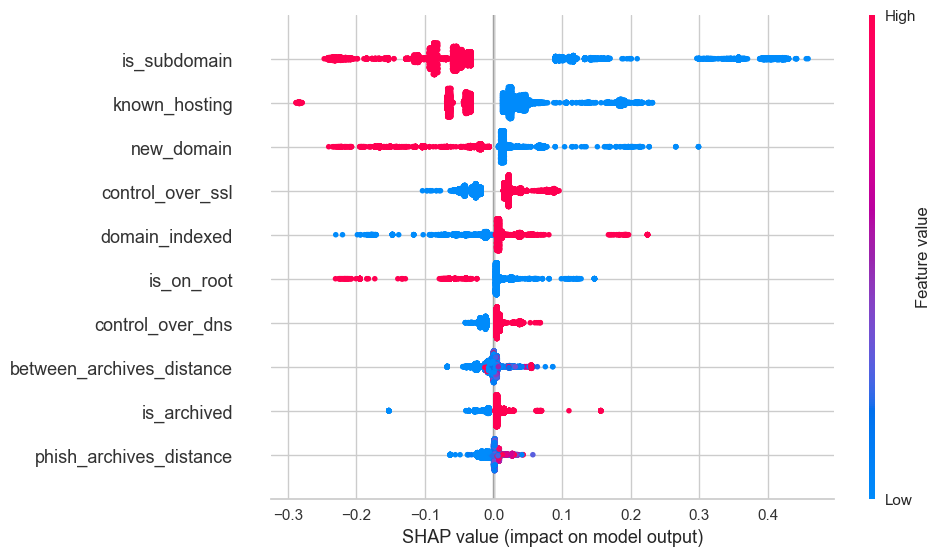

In [56]:
# Iterate over each class

import matplotlib.pyplot as plt

for class_idx in range(shap_values.shape[2]):

    # Plot the SHAP summary plot for the current class
    shap.summary_plot(shap_values[:, :, class_idx], handled_missed, show=False)

    # Adjust the layout
    plt.subplots_adjust(left=0.07, right=0.95, top=0.95, bottom=0.07)

    # Show or save the plot
    plt.show()